<a href="https://colab.research.google.com/github/zaccleong/Vehicle_Collision_Classification/blob/main/Copy_of_Vehicle_Side_Collision_Predection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sb
import pandas as pd
import glob
import csv
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split

In [ ]:
# Read the relevant training feature files and append a column of labels
training_list = [
                'features_export_side_relative_car0_20_car1_10_clean.csv',
                'features_export_side_relative_car0_20_car1_12_clean.csv',
                'features_export_side_relative_car0_20_car1_14_clean.csv',
                'features_export_side_relative_car0_20_car1_16_clean.csv',
                'features_export_side_relative_car0_20_car1_18_clean.csv',
                'features_export_side_relative_car0_20_car1_20_clean.csv',
                'features_export_side_relative_car0_20_car1_22_clean.csv',
                'features_export_side_relative_car0_20_car1_24_clean.csv',
                'features_export_side_relative_car0_20_car1_26_clean.csv',
                'features_export_side_relative_car0_20_car1_28_clean.csv',
                'features_export_side_relative_car0_20_car1_30_clean.csv']


# Specify your training features file location
PATH = "C:\\...\\features_csv\\"

feature_df_list = []
#Feature export CSV files
for file in glob.glob(PATH+"*.csv"):

    x = file.split("\\")
    
    if x[-1] in str(training_list):

        with open(file) as csvfile:
            feature = pd.read_csv(csvfile)
            
            collision_list = []
            # Append a column to the feature dataframe for the collision labels
            for i in range(len(feature)):
                if i >= (len(feature) - 31):
                    collision_label = 1
                else:
                    collision_label = 0                
                collision_list.append(collision_label)
                        
            feature['collision'] = collision_list
            feature_df_list.append(feature)

training_df_features = pd.concat(feature_df_list)

In [ ]:
final_training_df = training_df_features.drop(['Unnamed: 0', 'step'], axis = 1) 
final_training_df.to_csv("Train.csv")
final_training_df

,dist0,dist1,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,...,dist30,dist_min,dist_mean,projected_dist_1,projected_dist_2,projected_dist_3,projected_dist_min,projected_dist_mean,binary_intersect,collision
0,291.091639,288.855712,286.619785,284.383858,282.147932,279.912005,277.676079,275.440153,273.204228,270.968302,...,224.013943,224.013943,257.552768,268.732377,246.373142,224.013943,224.013943,246.373154,0,0
1,288.855712,286.619785,284.383858,282.147932,279.912005,277.676079,275.440153,273.204228,270.968302,268.732377,...,221.778025,221.778025,255.316845,266.496452,244.137221,221.778025,221.778025,244.137233,0,0
2,286.619785,284.383858,282.147932,279.912005,277.676079,275.440153,273.204228,270.968302,268.732377,266.496452,...,219.542108,219.542108,253.080923,264.260528,241.901299,219.542108,219.542108,241.901312,0,0
3,284.383858,282.147932,279.912005,277.676079,275.440153,273.204228,270.968302,268.732377,266.496452,264.260528,...,217.306191,217.306191,250.845000,262.024604,239.665378,217.306191,217.306191,239.665391,0,0
4,282.147932,279.912005,277.676079,275.440153,273.204228,270.968302,268.732377,266.496452,264.260528,262.024604,...,215.070275,215.070275,248.609078,259.788680,237.429458,215.070275,215.070275,237.429471,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,14.042827,10.453006,6.879410,3.373992,1.199151,4.181950,7.715961,11.295131,14.886925,18.483984,...,94.168211,1.199151,42.356757,0.000000,22.083736,58.119203,0.000000,26.734313,1,1
127,10.453006,6.879410,3.373992,1.199151,4.181950,7.715961,11.295131,14.886925,18.483984,22.083736,...,97.773280,1.199151,45.057739,0.000000,25.685049,61.723886,0.000000,29.136312,1,1
128,6.879409,3.373992,1.199151,4.181950,7.715961,11.295131,14.886925,18.483984,22.083736,25.685049,...,101.378367,1.199151,47.990815,0.000000,29.287347,65.328639,0.000000,31.538662,1,1
129,3.373992,1.199151,4.181950,7.715961,11.295131,14.886925,18.483984,22.083736,25.685049,29.287347,...,104.983469,1.199151,51.155463,0.000000,32.890306,68.933450,0.000000,33.941252,1,1


In [ ]:
# Training of RF model 
X = final_training_df.drop('collision', axis=1)
y = final_training_df['collision']

X_train = X
y_train = y

rf_clf = RandomForestClassifier(n_estimators = 2000, random_state=34)
rf_clf.fit(X_train, y_train)


xgb_clf = XGBClassifier(eta = '0.8',max_depth ='1' )
xgb_clf.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta='0.8', gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.800000012, max_delta_step=0, max_depth='1',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
print(X.shape, y.shape)

(1441, 39) (1441,)


In [ ]:
# ML model testing
# Specify your testing features file location
# PATH = "C:\\...\\features_csv\\"

testing_list = ['features_export_side_relative_car0_20_car1_11.csv',
                'features_export_side_relative_car0_20_car1_13.csv',
                'features_export_side_relative_car0_20_car1_15.csv',
                'features_export_side_relative_car0_20_car1_17.csv',
                'features_export_side_relative_car0_20_car1_19.csv',
                'features_export_side_relative_car0_20_car1_21.csv',
                'features_export_side_relative_car0_20_car1_23.csv',
                'features_export_side_relative_car0_20_car1_25.csv',
                'features_export_side_relative_car0_20_car1_27.csv',
                'features_export_side_relative_car0_20_car1_29.csv',
                'features_export_side_relative_car0_20_car1_31.csv']

feature_df_list = []
#Testing feature file
for file in glob.glob(PATH + "*.csv"):

    x = file.split("\\")
    
    if x[-1] in str(testing_list):

        with open(file) as csvfile:
            feature = pd.read_csv(csvfile)
            
            collision_list = []
            # Append a column to the feature dataframe for the collision labels
            for i in range(len(feature)):
                if i >= (len(feature) - 31):    
                    collision_label = 1
                else:
                    collision_label = 0
                
                collision_list.append(collision_label)
            
            feature['collision'] = collision_list
            feature_df_list.append(feature)

testing_df_features = pd.concat(feature_df_list)

testing_df_features.describe()

<bound method NDFrame.describe of      Unnamed: 0  step       dist0       dist1       dist2       dist3  \
0             0   783  296.685571  294.403207  292.120843  289.838480   
1             1   784  294.403207  292.120843  289.838480  287.556118   
2             2   785  292.120843  289.838480  287.556118  285.273757   
3             3   786  289.838480  287.556118  285.273757  282.991396   
4             4   787  287.556118  285.273757  282.991396  280.709036   
..          ...   ...         ...         ...         ...         ...   
126         126   500   15.147147   11.485088    7.848244    4.301058   
127         127   501   11.485088    7.848244    4.301058    1.618563   
128         128   502    7.848244    4.301058    1.618563    3.735891   
129         129   503    4.301057    1.618563    3.735891    7.246413   
130         130   504    1.618563    3.735891    7.246413   10.875689   

          dist4       dist5       dist6       dist7  ...      dist30  \
0    287.556118  

In [ ]:
final_testing_df = testing_df_features.drop(['Unnamed: 0', 'step'], axis = 1) 
final_testing_df.to_csv("Test.csv")

In [ ]:
# Testing of ML model and calculate precision, recall and F1 score


In [ ]:
# Testing of ML model 
X_test = final_testing_df.drop('collision', axis=1)
y_test = final_testing_df['collision']


y_pred_rf= rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
print("X Test Shape:",X_test.shape,"\n"
      "Y Test Shape:",y_test.shape)

X Test Shape: (1441, 39) 
Y Test Shape: (1441,)


Random Forest:
Precision Score: 0.9941520467836257
Recall Score: 0.9970674486803519
F1 Score: 0.9956076134699854


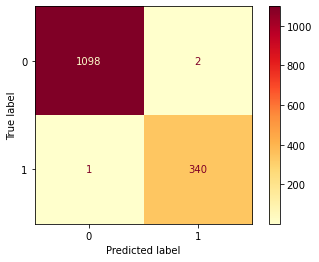

In [ ]:
#Evaluating RF model
print("Random Forest:")
print("Precision Score:", precision_score(y_test,y_pred_rf))
print("Recall Score:", recall_score(y_test,y_pred_rf))
print("F1 Score:", f1_score(y_test,y_pred_rf))

plot_confusion_matrix(rf_clf, X_test, y_test, labels=None, sample_weight=None, normalize=None, cmap='YlOrRd', ax=None)

XGBoost:
Precision Score: 0.9935897435897436
Recall Score: 0.9090909090909091
F1 Score: 0.9494640122511485


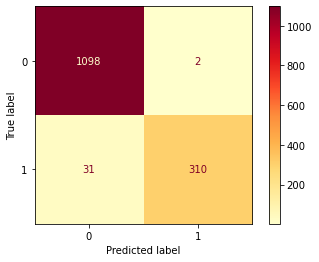

In [ ]:
#Evaluating XGB model
print("XGBoost:")
print("Precision Score:", precision_score(y_test,y_pred_xgb))
print("Recall Score:", recall_score(y_test,y_pred_xgb))
print("F1 Score:", f1_score(y_test,y_pred_xgb))

plot_confusion_matrix(xgb_clf, X_test, y_test, labels=None, sample_weight=None, normalize=None, cmap='YlOrRd', ax=None)

#Searching for best parameters


mlp_clf = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp_clf, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))










MLP:
Precision Score: 0.9941690962099126
Recall Score: 1.0
F1 Score: 0.9970760233918129


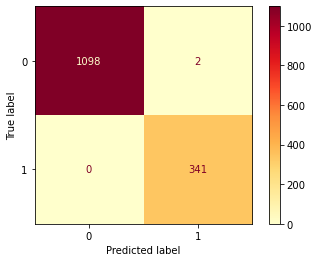

In [ ]:
mlp_clf = MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (50, 50, 50), learning_rate= 'constant', solver= 'sgd')

mlp_clf.fit(X_train, y_train)


y_pred_mlp = mlp_clf.predict(X_test)
#Evaluating DNN model
print("MLP:")
print("Precision Score:", precision_score(y_test,y_pred_mlp))
print("Recall Score:", recall_score(y_test,y_pred_mlp))
print("F1 Score:", f1_score(y_test,y_pred_mlp))

plot_confusion_matrix(mlp_clf, X_test, y_test, labels=None, sample_weight=None, normalize=None, cmap='YlOrRd', ax=None)

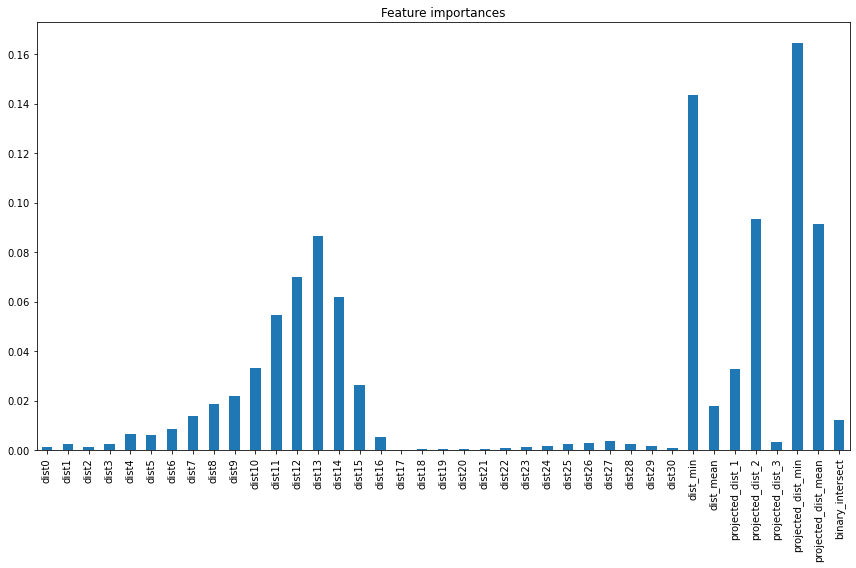

In [ ]:
#Plotting feature importances for Random Forest Model


features_clf = {}
#a dict to hold feature_name: feature_importance
for feature, importance in zip(final_testing_df.columns, rf_clf.feature_importances_):
    features_clf[feature] = importance #add the name/value pair 

rf_importances = pd.Series(rf_clf.feature_importances_, index = features_clf)    
    
fig, ax = plt.subplots()
rf_importances.plot.bar()
ax.set_title("Feature importances")
fig.tight_layout()

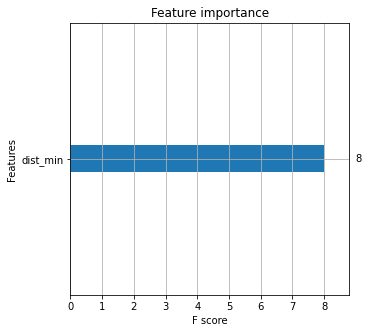

In [ ]:
#Plotting feature importances for XGBoost Model
xgboost.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

#Relative speed

NameError: name 'pyplot' is not defined

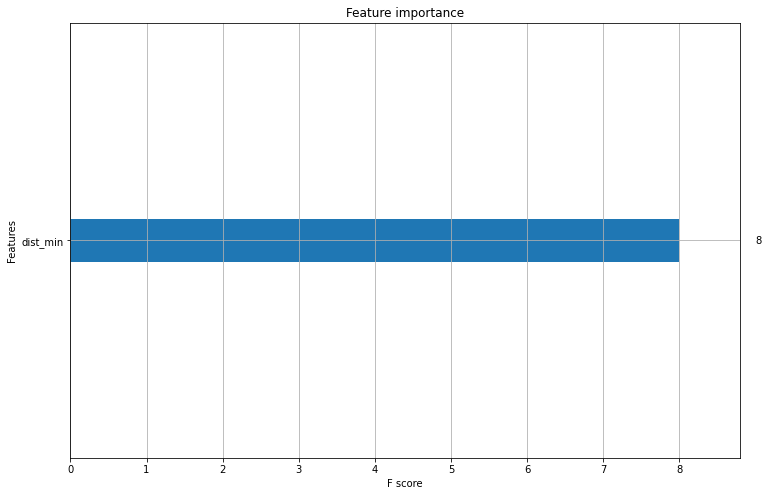

In [ ]:

# plot feature importance
xgboost.plot_importance(xgb_clf)
pyplot.show()

In [ ]:
print("Precision Score:\n","MLP:     ", precision_score(y_test,y_pred_mlp),"\n","RF:      ",
      precision_score(y_test,y_pred_rf),"\n","XGBoost: ",precision_score(y_test,y_pred_xgb))
print("Recall Score:\n","MLP:     ", recall_score(y_test,y_pred_mlp),"\n","RF:      ",
      recall_score(y_test,y_pred_rf),"\n","XGBoost: ",recall_score(y_test,y_pred_xgb))
print("F1 Score:\n","MLP:     ", f1_score(y_test,y_pred_mlp),"\n","RF:      ",
      f1_score(y_test,y_pred_rf),"\n","XGBoost: ",f1_score(y_test,y_pred_xgb))

Precision Score:
 MLP:      0.9941690962099126 
 RF:       0.9941520467836257 
 XGBoost:  0.9935897435897436
Recall Score:
 MLP:      1.0 
 RF:       0.9970674486803519 
 XGBoost:  0.9090909090909091
F1 Score:
 MLP:      0.9970760233918129 
 RF:       0.9956076134699854 
 XGBoost:  0.9494640122511485


In [ ]:
y=[]
y = final_training_df.iloc[:,-1]
y


0      0
1      0
2      0
3      0
4      0
      ..
126    1
127    1
128    1
129    1
130    1
Name: collision, Length: 1441, dtype: int64

In [ ]:
X_train_torch, X_test_torch, y_train_torch, y_test_torch = train_test_split(X, y, test_size=0.25, random_state=12)

In [ ]:
#X_train
#y_train
#X_test
#y_test

In [ ]:
scaler = StandardScaler()
X_train_torch = scaler.fit_transform(X_train_torch)
X_test_torch = scaler.transform(X_test_torch)
y_train_torch

68     0
66     0
110    1
15     0
59     0
      ..
39     0
104    1
86     0
98     0
104    1
Name: collision, Length: 1080, dtype: int64

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
# creating DataFrame from targets_data
targets_df = pd.DataFrame(data=y_train_torch)
targets_df.columns = ['targets']

# creating tensor from targets_df 
torch_tensor = torch.tensor(targets_df['targets'].values)
torch_tensor


tensor([0, 0, 1,  ..., 0, 0, 1])

In [ ]:
## train data

#y data = torch_tensor.values
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train_torch), 
                      torch_tensor)
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test_torch))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 39.
        self.layer_1 = nn.Linear(39, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=39, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
y_test_torch.shape[0]

361

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
       # print(X_batch, "break",y_batch)
        y_pred = model(X_batch)
        #Troubleshoot
        #print (y_pred.dtype)
        #print(y_batch.unsqueeze(1).dtype)
        #
        loss = criterion(y_pred, y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:3}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch   1: | Loss: 0.48650 | Acc: 80.765
Epoch   2: | Loss: 0.24718 | Acc: 96.412
Epoch   3: | Loss: 0.18470 | Acc: 98.471
Epoch   4: | Loss: 0.14023 | Acc: 99.000
Epoch   5: | Loss: 0.11798 | Acc: 98.647
Epoch   6: | Loss: 0.10014 | Acc: 99.000
Epoch   7: | Loss: 0.09880 | Acc: 98.353
Epoch   8: | Loss: 0.09360 | Acc: 98.471
Epoch   9: | Loss: 0.07040 | Acc: 99.000
Epoch  10: | Loss: 0.06632 | Acc: 98.647
Epoch  11: | Loss: 0.05309 | Acc: 99.235
Epoch  12: | Loss: 0.04606 | Acc: 99.412
Epoch  13: | Loss: 0.05460 | Acc: 98.706
Epoch  14: | Loss: 0.04916 | Acc: 98.941
Epoch  15: | Loss: 0.04006 | Acc: 99.118
Epoch  16: | Loss: 0.03759 | Acc: 99.235
Epoch  17: | Loss: 0.03670 | Acc: 99.235
Epoch  18: | Loss: 0.03447 | Acc: 99.294
Epoch  19: | Loss: 0.03068 | Acc: 99.353
Epoch  20: | Loss: 0.03263 | Acc: 99.118
Epoch  21: | Loss: 0.02964 | Acc: 99.176
Epoch  22: | Loss: 0.03342 | Acc: 99.000
Epoch  23: | Loss: 0.03319 | Acc: 99.176
Epoch  24: | Loss: 0.04244 | Acc: 98.882
Epoch  25: | Los

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
correct_results = (y_pred_list == y_test_torch).sum()
acccu=(correct_results/len(y_test_torch))*100
print(classification_report(y_test_torch, y_pred_list))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       276
           1       1.00      0.96      0.98        85

    accuracy                           0.99       361
   macro avg       0.99      0.98      0.99       361
weighted avg       0.99      0.99      0.99       361



In [ ]:
acccu

99.16897506925207

In [ ]:
#Evaluating on odd dataset
final_testing_df

,dist0,dist1,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,...,dist30,dist_min,dist_mean,projected_dist_1,projected_dist_2,projected_dist_3,projected_dist_min,projected_dist_mean,binary_intersect,collision
0,296.685571,294.403207,292.120843,289.838480,287.556118,285.273757,282.991396,280.709036,278.426676,276.144318,...,228.215007,228.215007,262.450221,273.861960,251.038430,228.215007,228.215007,251.038466,0,0
1,294.403207,292.120843,289.838480,287.556118,285.273757,282.991396,280.709036,278.426676,276.144318,273.861960,...,225.932671,225.932671,260.167869,271.579603,248.756083,225.932671,225.932671,248.756119,0,0
2,292.120843,289.838480,287.556118,285.273757,282.991396,280.709036,278.426676,276.144318,273.861960,271.579603,...,223.650338,223.650338,257.885519,269.297247,246.473736,223.650338,223.650338,246.473774,0,0
3,289.838480,287.556118,285.273757,282.991396,280.709036,278.426676,276.144318,273.861960,271.579603,269.297247,...,221.368005,221.368005,255.603169,267.014892,244.191391,221.368005,221.368005,244.191429,0,0
4,287.556118,285.273757,282.991396,280.709036,278.426676,276.144318,273.861960,271.579603,269.297247,267.014892,...,219.085674,219.085674,253.320820,264.732537,241.909047,219.085674,219.085674,241.909086,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,15.147147,11.485088,7.848244,4.301058,1.618563,3.735891,7.246413,10.875689,14.535034,18.206325,...,95.617693,1.618563,42.856738,0.000000,21.883552,58.736634,0.000000,26.873395,1,1
127,11.485088,7.848244,4.301058,1.618563,3.735891,7.246413,10.875689,14.535034,18.206325,21.883552,...,99.306137,1.618563,45.571544,0.000000,25.564153,62.424299,0.000000,29.329484,1,1
128,7.848244,4.301058,1.618563,3.735891,7.246413,10.875689,14.535034,18.206325,21.883552,25.564153,...,102.994617,1.618563,48.523465,0.000000,29.246853,66.112106,0.000000,31.786320,1,1
129,4.301057,1.618563,3.735891,7.246413,10.875689,14.535034,18.206325,21.883552,25.564153,29.246853,...,106.683129,1.618563,51.711687,0.000000,32.930950,69.800032,0.000000,34.243660,1,1


In [ ]:
#TEMPLATE
# X = final_training_df.drop('collision', axis=1)
# y = final_training_df['collision']

# X_train = X
# y_train = y
# test_data = testData(torch.FloatTensor(X_test))
# test_loader = DataLoader(dataset=test_data, batch_size=1

In [ ]:
X_test_odd = final_testing_df.drop('collision',axis=1)
X_test_odd = scaler.transform(X_test_odd)
test_data_odd = testData(torch.FloatTensor(X_test_odd))
test_loader_odd = DataLoader(dataset=test_data_odd, batch_size=1)

In [ ]:
y_pred_list_odd = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader_odd:
        X_batch = X_batch.to(device)
        y_test_pred_odd = model(X_batch)
        y_test_pred_odd = torch.sigmoid(y_test_pred_odd)
        y_pred_tag_odd = torch.round(y_test_pred_odd)
        y_pred_list_odd.append(y_pred_tag_odd.cpu().numpy())

y_pred_list_odd = [a.squeeze().tolist() for a in y_pred_list_odd]

In [ ]:
correct_results_odd = (y_pred_list_odd == final_testing_df['collision']).sum()
acccu_odd=(correct_results_odd/len(final_testing_df))*100
print(classification_report(final_testing_df['collision'], y_pred_list_odd))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1100
           1       1.00      0.98      0.99       341

    accuracy                           0.99      1441
   macro avg       1.00      0.99      0.99      1441
weighted avg       0.99      0.99      0.99      1441



In [ ]:
acccu_odd

99.44482997918112

In [ ]:
print("Precision Score:\n","MLP:     ", precision_score(y_test,y_pred_mlp),'\n',"Pytorch: ",precision_score(final_testing_df['collision'],y_pred_list_odd),"\n","RF:      ",
      precision_score(y_test,y_pred_rf),"\n","XGBoost: ",precision_score(y_test,y_pred_xgb))
print("Recall Score:\n","MLP:     ", recall_score(y_test,y_pred_mlp),'\n',"Pytorch: ",recall_score(final_testing_df['collision'],y_pred_list_odd),"\n","RF:      ",
      recall_score(y_test,y_pred_rf),"\n","XGBoost: ",recall_score(y_test,y_pred_xgb))
print("F1 Score:\n","MLP:     ", f1_score(y_test,y_pred_mlp),'\n',"Pytorch: ",f1_score(final_testing_df['collision'],y_pred_list_odd),"\n","RF:      ",
      f1_score(y_test,y_pred_rf),"\n","XGBoost: ",f1_score(y_test,y_pred_xgb))

Precision Score:
 MLP:      0.9941690962099126 
 Pytorch:  1.0 
 RF:       0.9941520467836257 
 XGBoost:  0.9935897435897436
Recall Score:
 MLP:      1.0 
 Pytorch:  0.9765395894428153 
 RF:       0.9970674486803519 
 XGBoost:  0.9090909090909091
F1 Score:
 MLP:      0.9970760233918129 
 Pytorch:  0.9881305637982196 
 RF:       0.9956076134699854 
 XGBoost:  0.9494640122511485


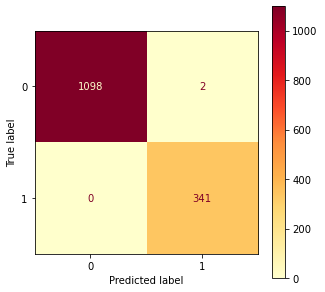

In [ ]:
plot_confusion_matrix(mlp_clf, X_test, y_test, labels=None, sample_weight=None, normalize=None, cmap='YlOrRd', ax=None)

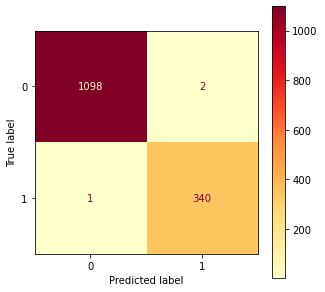

In [ ]:
plot_confusion_matrix(rf_clf, X_test, y_test, labels=None, sample_weight=None, normalize=None, cmap='YlOrRd', ax=None)

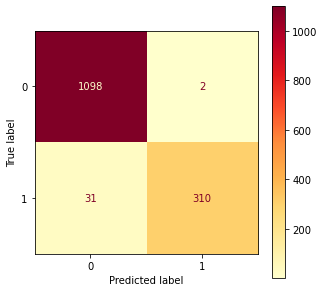

In [ ]:
plot_confusion_matrix(xgb_clf, X_test, y_test, labels=None, sample_weight=None, normalize=None, cmap='YlOrRd', ax=None)

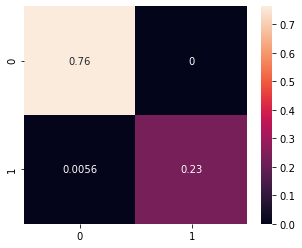

In [ ]:
cf_matrix = confusion_matrix(final_testing_df['collision'],y_pred_list_odd)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix))
plt.figure(figsize = (5,4))
sb.heatmap(df_cm, annot=True)
plt.savefig('output.png')